<a href="https://colab.research.google.com/github/febse/ts2025-presentations-2-boyana/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TS 2025 - Assignment 2

Before you begin, set the assignment seed to the student id of one of your team members in the cell below.
To choose the data for this set the assignment seed to the student id of one of the team members. The
cell is prefilled with an **example** student id, so make sure to change it and **run the cell** before proceeding
further.

In [3]:
# NB!: change this to the student id of one of your team members

assignment_seed = "5EB0100068"

## Presentation

Do not create powerpoint slides or similar presentations for this assignment. The only submission should be
this Jupyter notebook with the completed code and results.

For the presentation of your results please **only include**:

    - Plots
    - Numeric results
    - Tables of model parameters and summaries

**Do not include**:

    - Text in comments or markdown cells
    - Custom functions in the code
    - if-then-else statements or similar control flow structures
    - Loops (for, while, etc.)
    - Any other code that is not directly related to the assignment tasks
  
**Explanations**

For the presentation you should be able to explain all the steps and be able to answer questions about

- Why you use a specific model/test/plot
- What is shown in the plots and numeric results
- How to interpret the results
  
## Tasks

1. Run the following cell to load your data. It will be stored in the pandas Series `dt`. All time series
are stock prices from the SOFIX index. The data that you should use for the model selection is stored in the
series `train`. The data for testing the forecasts is stored in the series `test`.

2. Adjust the labels and titles of the plots to reflect the stock you are analyzing
3. Your task is to select an ARIMA model for the stock price.
   - Choose the order of differencing based on the ACF/PACF plots and unit root tests (ADF, KPSS)
   - Choose the AR and MA orders based on the ACF/PACF plots and information criteria (AIC, BIC)
4. After selecting the ARIMA model, analyze the residuals
   - Plot the residuals and their ACF/PACF
   - Perform the Ljung-Box test on the residuals
   - Plot the histogram and QQ-plot of the residuals
5. Analyze the volatility of the residuals using an appropriate plot
6. Fit several ARCH/GARCH models to the residuals
   - Plot the conditional volatility
   - Analyze the standardized residuals of the GARCH model (plots, Ljung-Box test, histogram, QQ-plot)
   - Test whether negative and positive shocks have different effects on volatility
  
7. Forecast the stock prices for the test period using the ARIMA model in two ways:
   - By manually differencing the data before fitting the ARIMA model
   - By using the integrated ARIMA model directly
   - Compare the forecasts from both methods and explain the differences, explain the meaning of an
     intercept in the ARIMA model with differenced data
   - Plot the forecasts along with the actual values
   - Compute the RMSE of the forecasts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 20.0 MB/s eta 0:00:00


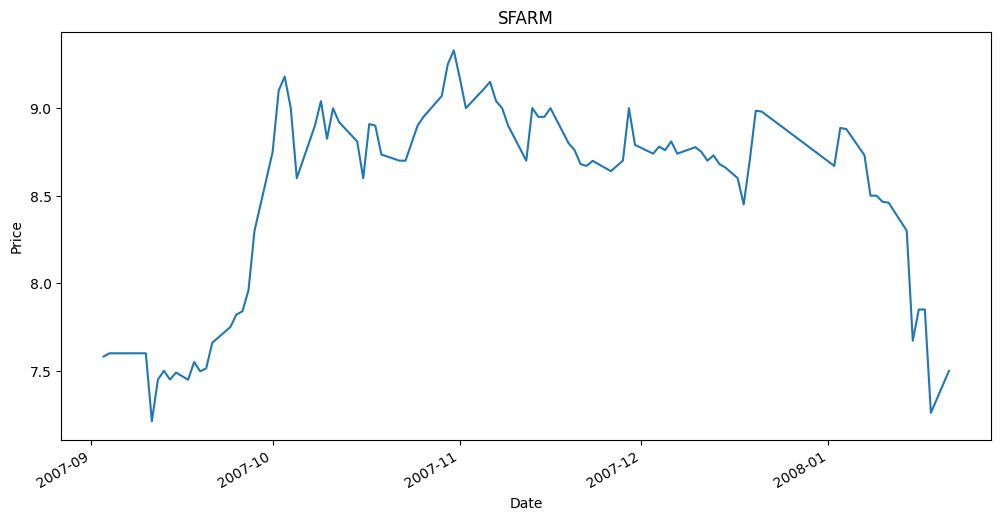

In [4]:
# Import libraries

%pip install arch

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
import numpy as np

np.random.seed(int(re.sub(r"\D", "", assignment_seed)))

stocks = pd.read_excel("https://github.com/febse/data/raw/refs/heads/main/ts/SOFIX-Stocks.xlsx", usecols="A:Q").set_index("Date")

dt = stocks[np.random.choice(stocks.columns)]

# Split the data into training and test sets

train_size = int(len(dt) * 0.85)
train, test = dt[:train_size], dt[train_size:]

# Plot the training data

train.plot(title="Stock Price", figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SFARM")
plt.show()

In [5]:
train

,SFARM
Date,
2007-09-03,7.582
2007-09-04,7.600
2007-09-05,7.600
2007-09-10,7.600
2007-09-11,7.212
...,...
2008-01-15,7.672
2008-01-16,7.850
2008-01-17,7.850


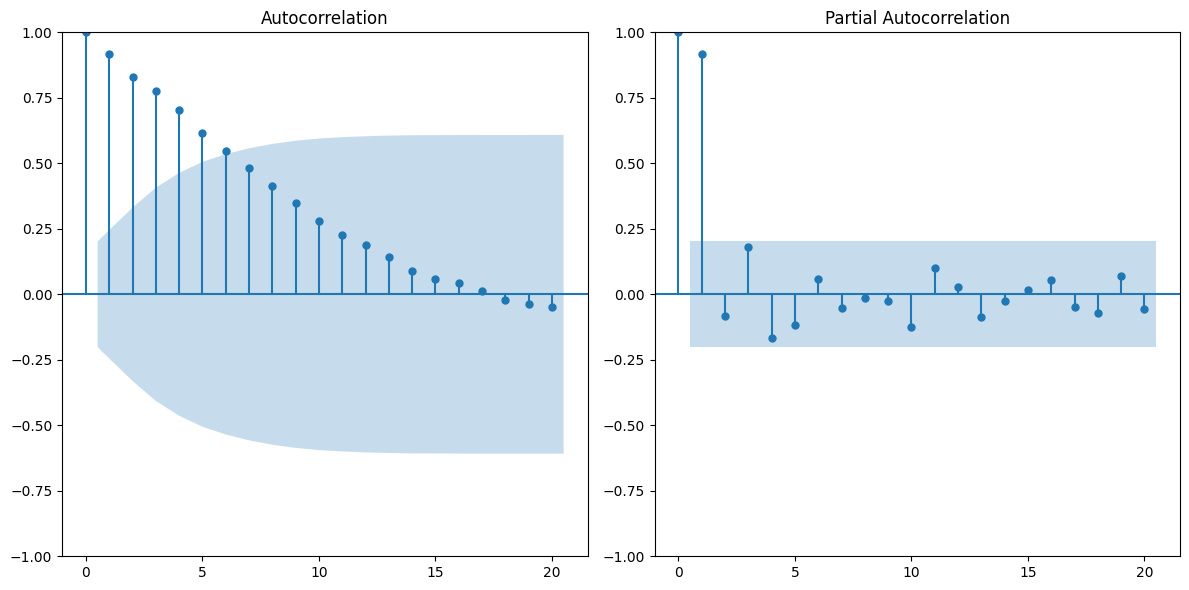

In [6]:
fix, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(np.log(train), ax=ax[0], lags=20)
plot_pacf(np.log(train), ax=ax[1], lags=20)
plt.tight_layout()
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

#ADF
adf_result = adfuller(train)
print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2f}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.2f}')

ADF Statistic: -1.57
p-value: 0.50
Critical Values:
	1%: -3.51
	5%: -2.89
	10%: -2.58


In [8]:
#KPSS
kpss_result = kpss(train)
print(f'KPSS Statistic: {kpss_result[0]:.2f}')
print(f'p-value: {kpss_result[1]:.2f}')
print(f'Critical Values:')
for key, value in kpss_result[3].items():
    print(f'\t{key}: {value:.2f}')

KPSS Statistic: 0.47
p-value: 0.05
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


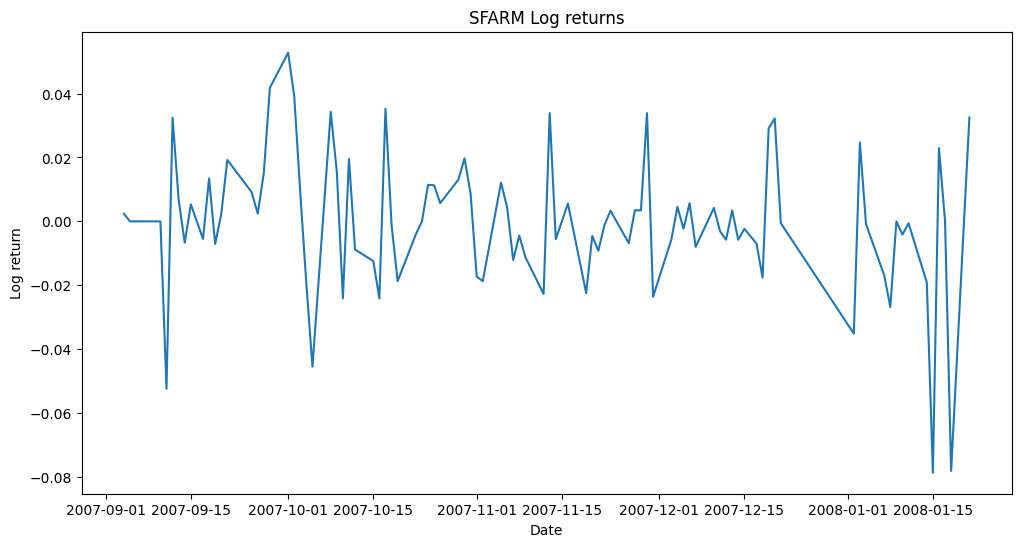

In [9]:
train_lr = np.log(train).diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(train_lr)
plt.title('SFARM Log returns')
plt.xlabel('Date')
plt.ylabel('Log return')
plt.show()

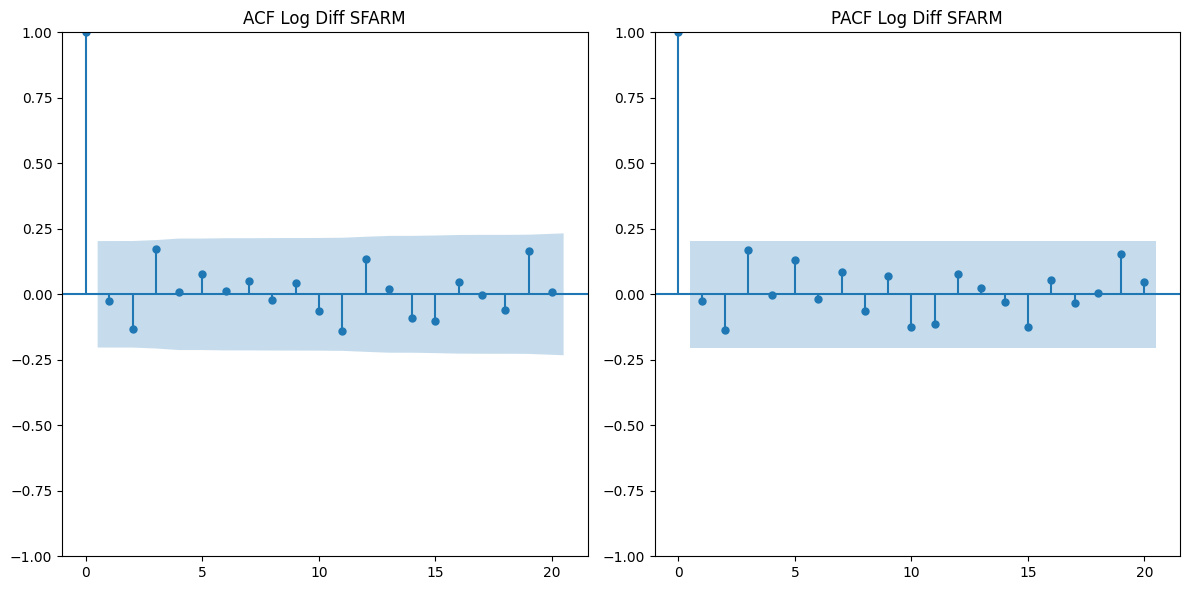

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(train_lr, ax=ax[0], lags=20)
plot_pacf(train_lr, ax=ax[1], lags=20)
ax[0].set_title(f'ACF Log Diff {dt.name}')
ax[1].set_title(f'PACF Log Diff {dt.name}')
plt.tight_layout()
plt.show()

In [11]:
#ADF

adf_result = adfuller(train_lr.dropna())
print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.2f}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.2f}')


ADF Statistic: -4.76
p-value: 0.00
Critical Values:
	1%: -3.51
	5%: -2.89
	10%: -2.58


In [12]:
fit_ARIMA = ARIMA(np.log(train), order=(2,1,0)).fit()
print(fit_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  SFARM   No. Observations:                   94
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 224.823
Date:                Thu, 15 Jan 2026   AIC                           -443.646
Time:                        13:18:01   BIC                           -436.048
Sample:                             0   HQIC                          -440.578
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0211      0.098     -0.214      0.830      -0.214       0.172
ar.L2         -0.1593      0.146     -1.091      0.275      -0.446       0.127
sigma2         0.0005   5.07e-05      9.174      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
fit_ARIMA1 = ARIMA(np.log(train), order=(1,1,0)).fit()
print(fit_ARIMA1.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SFARM   No. Observations:                   94
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 223.849
Date:                Thu, 15 Jan 2026   AIC                           -443.697
Time:                        13:18:01   BIC                           -438.632
Sample:                             0   HQIC                          -441.652
                                 - 94                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0263      0.087     -0.301      0.763      -0.197       0.145
sigma2         0.0005   4.78e-05      9.944      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [14]:
model_arma = train_lr.dropna()
fit_ARMA = ARIMA(model_arma, order=(2,0,0)).fit()
print(fit_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  SFARM   No. Observations:                   93
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 224.824
Date:                Thu, 15 Jan 2026   AIC                           -441.648
Time:                        13:18:01   BIC                           -431.518
Sample:                             0   HQIC                          -437.558
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.462e-05      0.002     -0.030      0.976      -0.004       0.004
ar.L1         -0.0208      0.100     -0.208      0.836      -0.217       0.176
ar.L2         -0.1552      0.159     -0.976      0.3

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
model_arma1 = train_lr.dropna()
fit_ARMA1 = ARIMA(model_arma, order=(1,0,0)).fit()
print(fit_ARMA1.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  SFARM   No. Observations:                   93
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 223.850
Date:                Thu, 15 Jan 2026   AIC                           -441.701
Time:                        13:18:01   BIC                           -434.103
Sample:                             0   HQIC                          -438.633
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.002     -0.054      0.957      -0.005       0.004
ar.L1         -0.0264      0.087     -0.304      0.761      -0.197       0.144
sigma2         0.0005   5.08e-05      9.353      0.0

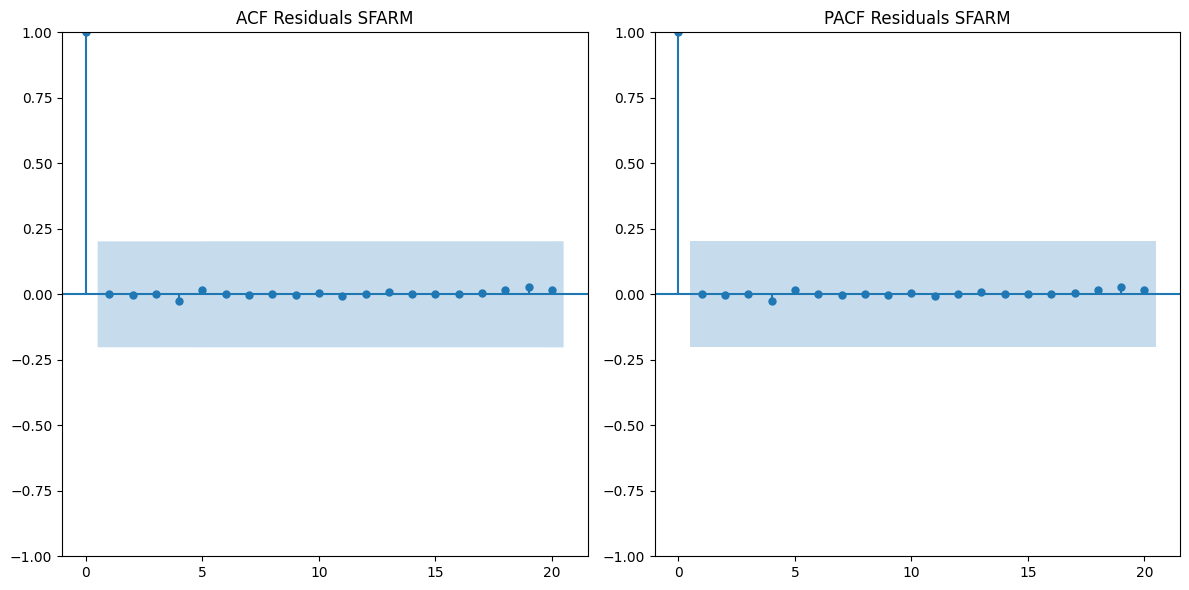

In [16]:
residuals_ARIMA1 = fit_ARIMA1.resid
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(residuals_ARIMA1, ax=ax[0], lags=20)
plot_pacf(residuals_ARIMA1, ax=ax[1], lags=20)
ax[0].set_title(f'ACF Residuals {dt.name}')
ax[1].set_title(f'PACF Residuals {dt.name}')
plt.tight_layout()
plt.show()

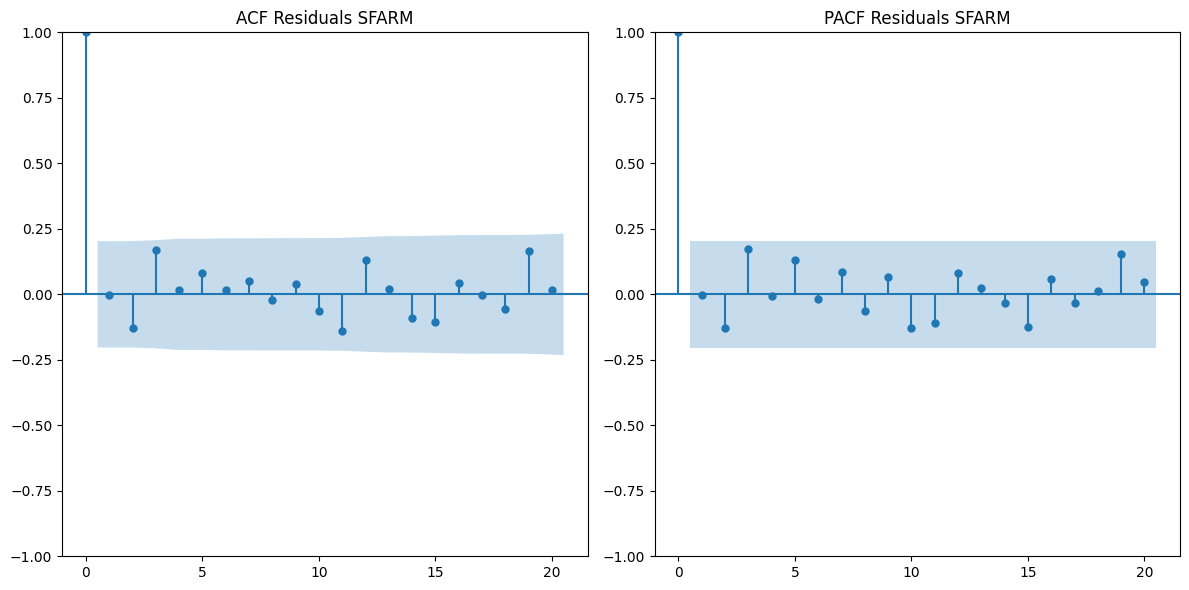

In [17]:
residuals_ARMA1 = fit_ARMA1.resid
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(residuals_ARMA1, ax=ax[0], lags=20)
plot_pacf(residuals_ARMA1, ax=ax[1], lags=20)
ax[0].set_title(f'ACF Residuals {dt.name}')
ax[1].set_title(f'PACF Residuals {dt.name}')
plt.tight_layout()
plt.show()

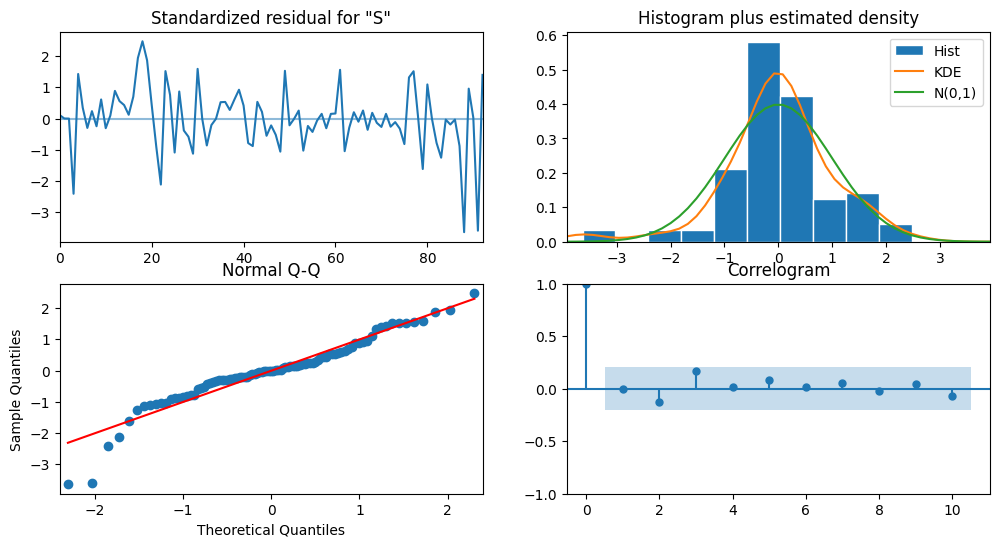

In [18]:
fit_ARIMA1.plot_diagnostics(figsize=(12,6))
plt.show()

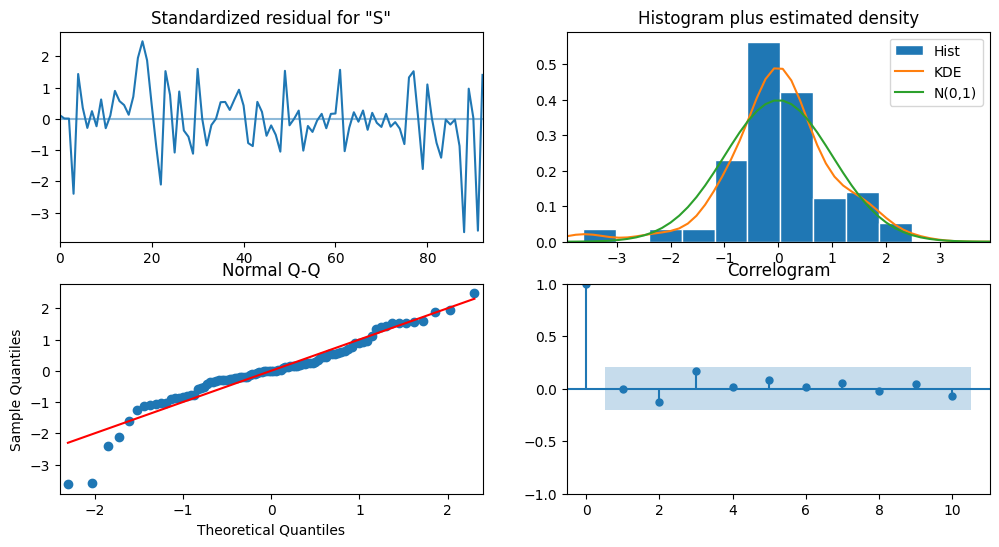

In [19]:
fit_ARMA1.plot_diagnostics(figsize=(12,6))
plt.show()

In [20]:
lb_serial_cor = fit_ARIMA1.test_serial_correlation('ljungbox', lags=20)
for i, (stat, p) in enumerate(zip(lb_serial_cor[0][0], lb_serial_cor[0][1])): print(f'Lag {i+1}: Statistic={stat:.3f}, p-value={p:.3f}')

Lag 1: Statistic=0.001, p-value=0.972
Lag 2: Statistic=1.615, p-value=0.446
Lag 3: Statistic=4.455, p-value=0.216
Lag 4: Statistic=4.476, p-value=0.345
Lag 5: Statistic=5.139, p-value=0.399
Lag 6: Statistic=5.166, p-value=0.523
Lag 7: Statistic=5.446, p-value=0.606
Lag 8: Statistic=5.488, p-value=0.704
Lag 9: Statistic=5.666, p-value=0.773
Lag 10: Statistic=6.117, p-value=0.805
Lag 11: Statistic=8.183, p-value=0.697
Lag 12: Statistic=10.039, p-value=0.613
Lag 13: Statistic=10.086, p-value=0.687
Lag 14: Statistic=11.018, p-value=0.685
Lag 15: Statistic=12.261, p-value=0.659
Lag 16: Statistic=12.491, p-value=0.710
Lag 17: Statistic=12.493, p-value=0.769
Lag 18: Statistic=12.878, p-value=0.799
Lag 19: Statistic=16.176, p-value=0.646
Lag 20: Statistic=16.205, p-value=0.704


In [21]:
lb_serial_cor = fit_ARMA1.test_serial_correlation('ljungbox', lags=20)
for i, (stat, p) in enumerate(zip(lb_serial_cor[0][0], lb_serial_cor[0][1])): print(f'Lag {i+1}: Statistic={stat:.3f}, p-value={p:.3f}')

Lag 1: Statistic=0.001, p-value=0.972
Lag 2: Statistic=1.614, p-value=0.446
Lag 3: Statistic=4.454, p-value=0.216
Lag 4: Statistic=4.475, p-value=0.345
Lag 5: Statistic=5.138, p-value=0.399
Lag 6: Statistic=5.165, p-value=0.523
Lag 7: Statistic=5.445, p-value=0.606
Lag 8: Statistic=5.487, p-value=0.704
Lag 9: Statistic=5.665, p-value=0.773
Lag 10: Statistic=6.116, p-value=0.805
Lag 11: Statistic=8.182, p-value=0.697
Lag 12: Statistic=10.037, p-value=0.613
Lag 13: Statistic=10.084, p-value=0.687
Lag 14: Statistic=11.017, p-value=0.685
Lag 15: Statistic=12.260, p-value=0.659
Lag 16: Statistic=12.490, p-value=0.710
Lag 17: Statistic=12.492, p-value=0.769
Lag 18: Statistic=12.877, p-value=0.799
Lag 19: Statistic=16.174, p-value=0.646
Lag 20: Statistic=16.203, p-value=0.704


<function matplotlib.pyplot.show(close=None, block=None)>

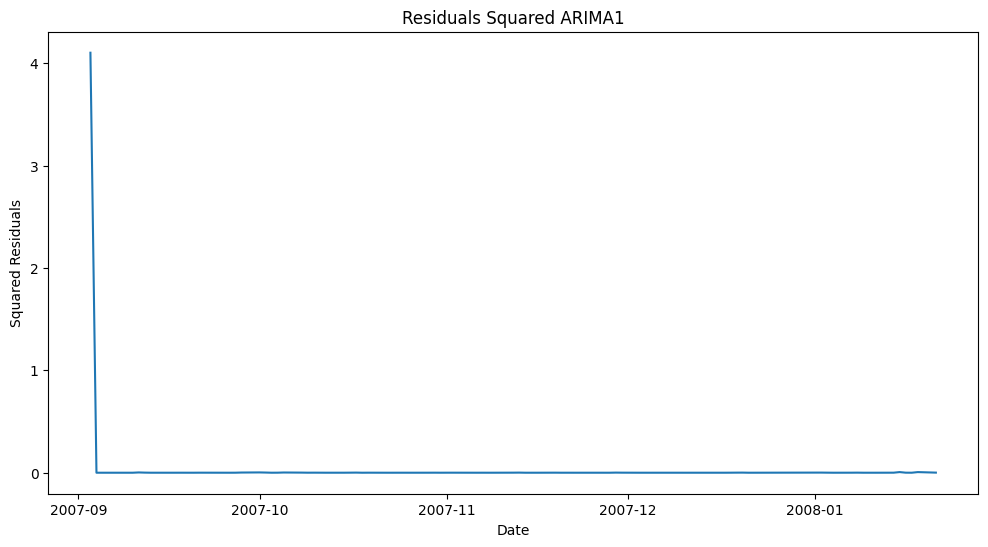

In [22]:
plt.figure(figsize=(12,6))
plt.plot(residuals_ARIMA1.index, residuals_ARIMA1**2)
plt.title('Residuals Squared ARIMA1')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

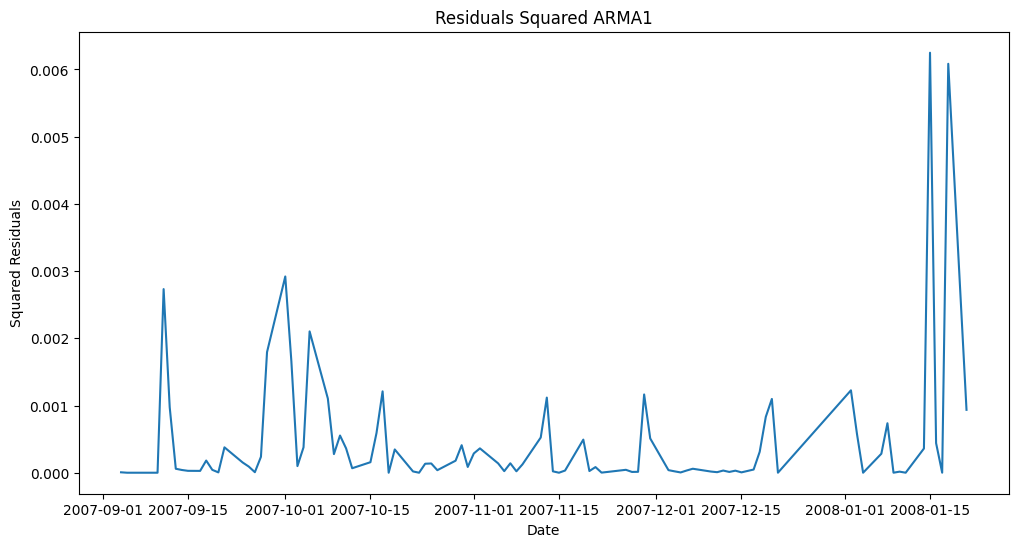

In [23]:
plt.figure(figsize=(12,6))
plt.plot(residuals_ARMA1.index, residuals_ARMA1**2)
plt.title('Residuals Squared ARMA1')
plt.xlabel('Date')
plt.ylabel('Squared Residuals')
plt.show

In [24]:
model = arch_model((fit_ARIMA1.resid*100), mean='Constant', vol='GARCH', p=1, q=1, o=0, dist='t')
fit_GARCH1 = model.fit(disp='off')
print(fit_GARCH1.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -211.506
Distribution:      Standardized Student's t   AIC:                           433.011
Method:                  Maximum Likelihood   BIC:                           445.728
                                              No. Observations:                   94
Date:                      Thu, Jan 15 2026   Df Residuals:                       93
Time:                              13:18:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

In [25]:
model = arch_model((fit_ARMA1.resid*100), mean='Constant', vol='GARCH', p=1, q=1, o=0, dist='t')
fit_GARCH11 = model.fit(disp='off')
print(fit_GARCH11.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -193.144
Distribution:      Standardized Student's t   AIC:                           396.288
Method:                  Maximum Likelihood   BIC:                           408.951
                                              No. Observations:                   93
Date:                      Thu, Jan 15 2026   Df Residuals:                       92
Time:                              13:18:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
fit_GARCH1_res = fit_GARCH1.std_resid.dropna()
ljung_box = acorr_ljungbox(fit_GARCH1_res, lags=[1, 5, 10, 20], return_df=True)
print(ljung_box)

     lb_stat  lb_pvalue
1   0.000735   0.978368
5   1.745977   0.883057
10  1.782023   0.997754
20  5.931874   0.998986


In [27]:
fit_GARCH11_res = fit_GARCH11.std_resid.dropna()
ljung_box = acorr_ljungbox(fit_GARCH11_res, lags=[1, 5, 10, 20], return_df=True)
print(ljung_box)

      lb_stat  lb_pvalue
1    0.094211   0.758891
5    6.270016   0.280825
10   7.071200   0.718707
20  18.059871   0.583464


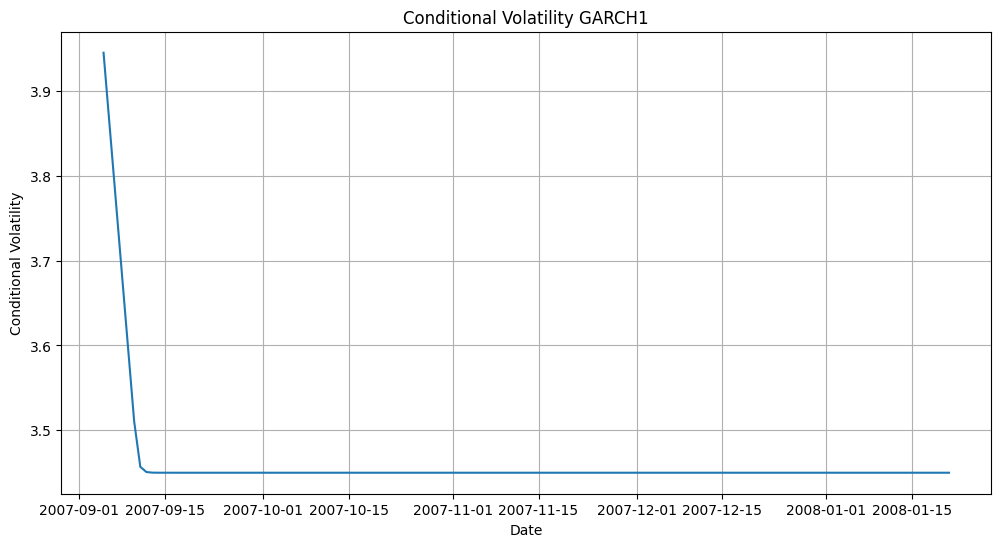

In [28]:
plt.figure(figsize=(12,6))
plt.plot(fit_GARCH1.conditional_volatility[2:])
plt.title('Conditional Volatility GARCH1')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

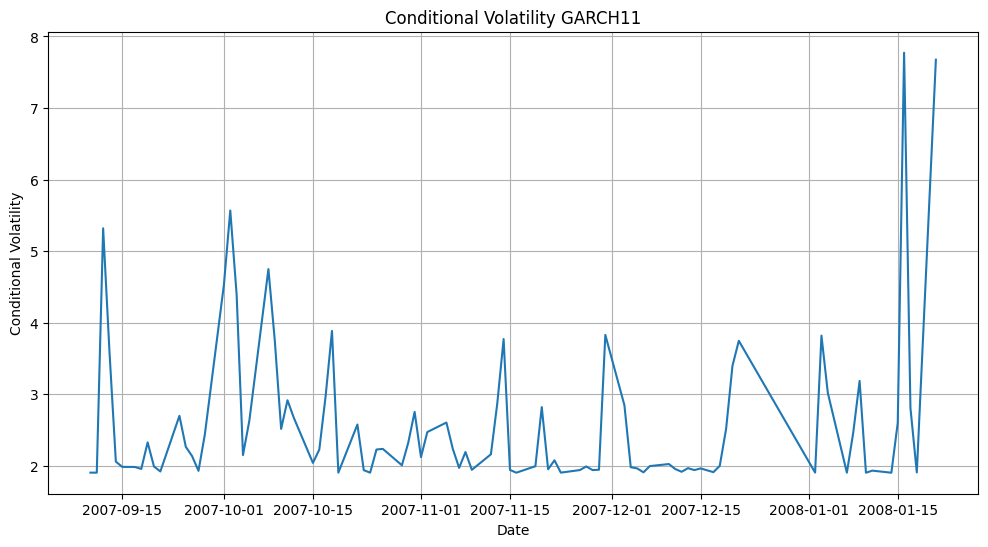

In [29]:
plt.figure(figsize=(12,6))
plt.plot(fit_GARCH11.conditional_volatility[2:])
plt.title('Conditional Volatility GARCH11')
plt.xlabel('Date')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

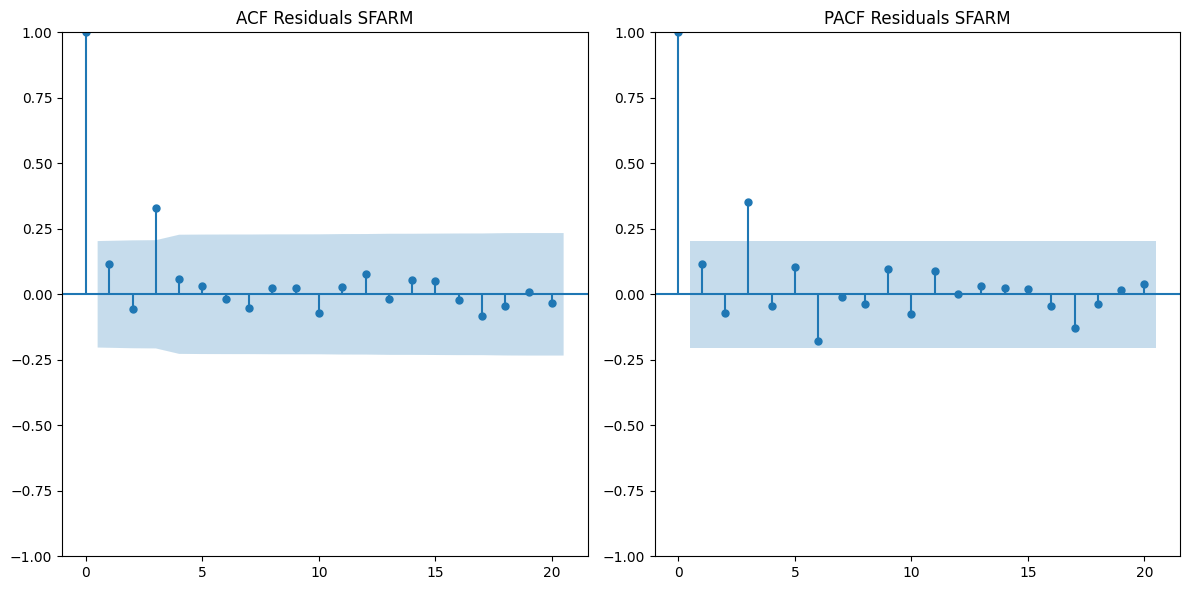

In [30]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(fit_GARCH1_res[1:]**2, ax=ax[0], lags=20)
plot_pacf(fit_GARCH1_res[1:]**2, ax=ax[1], lags=20)
ax[0].set_title(f'ACF Residuals {dt.name}')
ax[1].set_title(f'PACF Residuals {dt.name}')
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

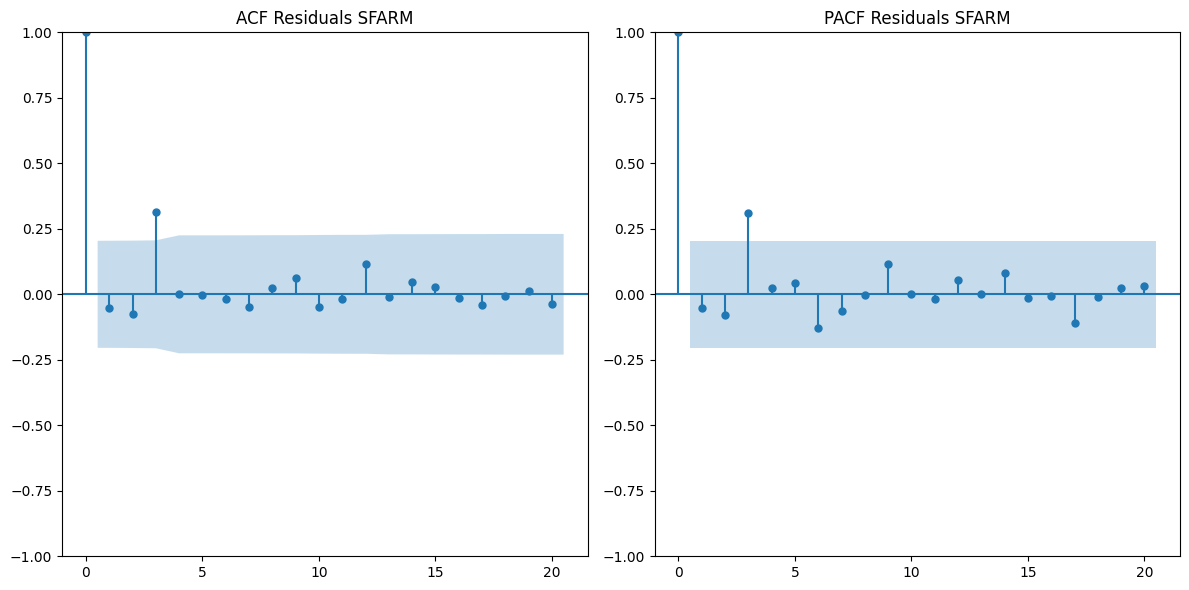

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
plot_acf(fit_GARCH11_res[1:]**2, ax=ax[0], lags=20)
plot_pacf(fit_GARCH11_res[1:]**2, ax=ax[1], lags=20)
ax[0].set_title(f'ACF Residuals {dt.name}')
ax[1].set_title(f'PACF Residuals {dt.name}')
plt.tight_layout()
plt.show

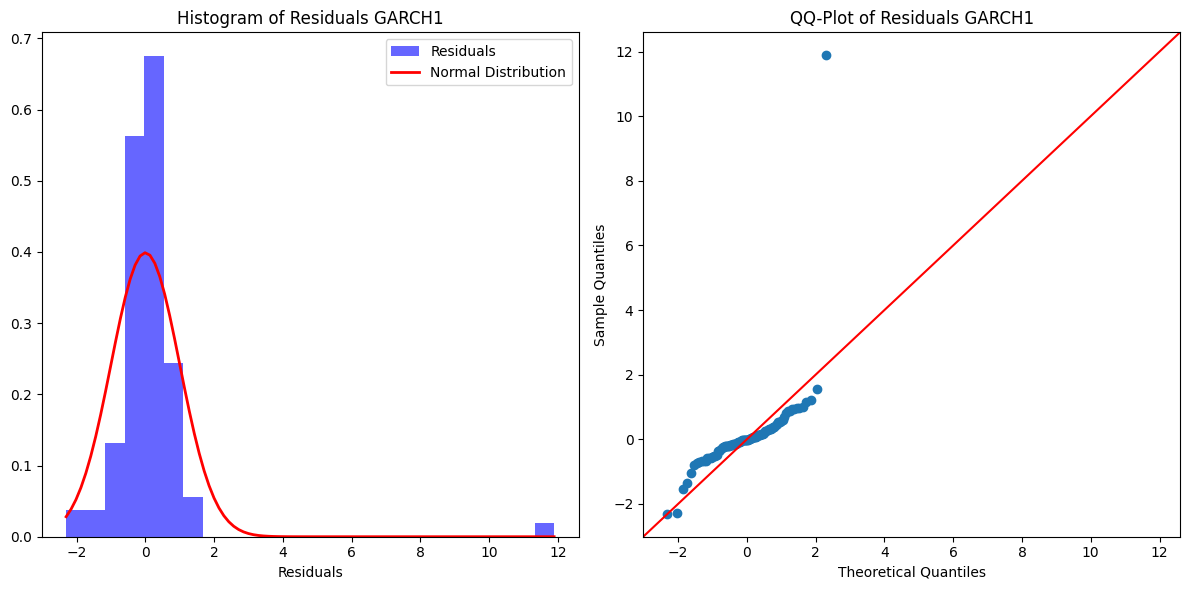

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(fit_GARCH1_res[0:], bins=25, density=True, alpha=0.6, color='b', label='Residuals')
x = np.linspace(fit_GARCH1_res[0:].min(), fit_GARCH1_res[0:].max(), 100)
ax[0].plot(x, stats.norm.pdf(x, loc=0, scale=1), 'r', lw=2, label='Normal Distribution')
ax[0].set_title('Histogram of Residuals GARCH1')
ax[0].set_xlabel('Residuals')
ax[0].legend()

sm.qqplot(fit_GARCH1_res[0:], line='45', ax=ax[1])
ax[1].set_title('QQ-Plot of Residuals GARCH1')
plt.tight_layout()
plt.show()

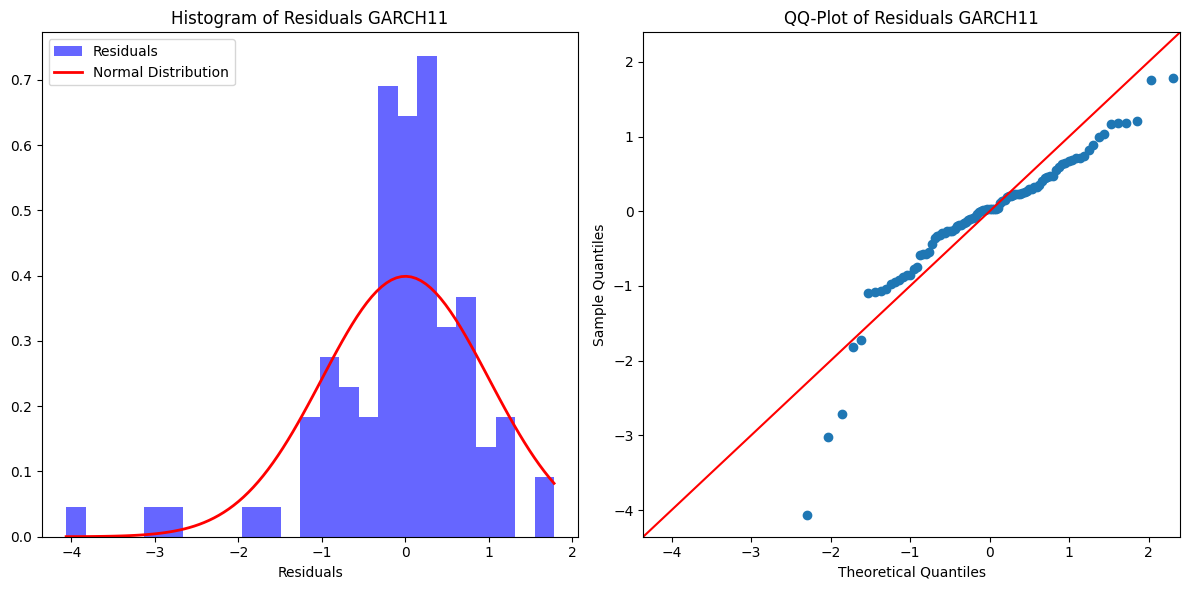

In [33]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(fit_GARCH11_res[0:], bins=25, density=True, alpha=0.6, color='b', label='Residuals')
x = np.linspace(fit_GARCH11_res[0:].min(), fit_GARCH11_res[0:].max(), 100)
ax[0].plot(x, stats.norm.pdf(x, loc=0, scale=1), 'r', lw=2, label='Normal Distribution')
ax[0].set_title('Histogram of Residuals GARCH11')
ax[0].set_xlabel('Residuals')
ax[0].legend()

sm.qqplot(fit_GARCH11_res[0:], line='45', ax=ax[1])
ax[1].set_title('QQ-Plot of Residuals GARCH11')
plt.tight_layout()
plt.show()

In [34]:
forecast = fit_ARIMA1.forecast(steps=10)
print("10-step forecast:")
print(forecast)

10-step forecast:
94     2.014048
95     2.014071
96     2.014070
97     2.014070
98     2.014070
99     2.014070
100    2.014070
101    2.014070
102    2.014070
103    2.014070
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
forecast = fit_ARMA1.forecast(steps=10)
print("10-step forecast:")
print(forecast)

10-step forecast:
93    -0.000991
94    -0.000106
95    -0.000129
96    -0.000128
97    -0.000128
98    -0.000128
99    -0.000128
100   -0.000128
101   -0.000128
102   -0.000128
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


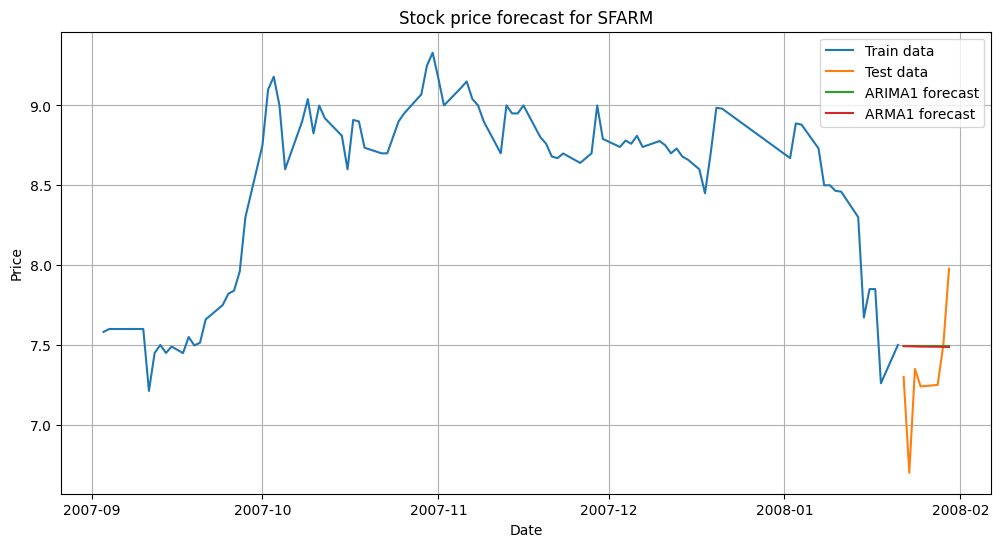

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forecast_steps = len(test.dropna())
ARIMA1_price_forecast_raw = fit_ARIMA1.forecast(steps=forecast_steps)
ARIMA1_price_forecast = pd.Series(ARIMA1_price_forecast_raw.values, index=test.dropna().index)

last_train_price = train.iloc[-1]
ARMA1_lr_forecast_raw = fit_ARMA1.forecast(steps=forecast_steps)
ARMA1_lr_forecast = pd.Series(ARMA1_lr_forecast_raw.values, index=test.dropna().index)

ARMA1_price_forecast = last_train_price * np.exp(ARMA1_lr_forecast.cumsum())
ARIMA1_price_forecast1 = np.exp(ARIMA1_price_forecast)

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train data')
plt.plot(test.dropna().index, test.dropna(), label='Test data')
plt.plot(ARIMA1_price_forecast1.index, ARIMA1_price_forecast1, label='ARIMA1 forecast')
plt.plot(ARMA1_price_forecast.index, ARMA1_price_forecast, label='ARMA1 forecast')

plt.title(f'Stock price forecast for {dt.name}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import mean_squared_error

actual_test_data = test.dropna()
rmse_ARIMA1 = np.sqrt(mean_squared_error(actual_test_data, ARIMA1_price_forecast1))
print(f'RMSE ARIMA1: {rmse_ARIMA1}')
rmse_ARMA1 = np.sqrt(mean_squared_error(actual_test_data, ARMA1_price_forecast))
print(f'RMSE ARMA1: {rmse_ARMA1}')


RMSE ARIMA1: 0.38648028296548564
RMSE ARMA1: 0.38611620664983126
